In [101]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import *
from qucat import Network,L,J,C,R
from modeling.qubits.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck
import scqubits as scq
from scqubits import ParameterSweep

In [102]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200) 
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

In [103]:
# Correction for next time...
# C = clockmon_lib(100)
# CR = C[0,1] + C[0,2] + C[0,0] - (C[0,1] + C[0,2])**2 / (C[0,1] + C[0,2] + C[1,1] + C[2,2])
# CR

In [104]:
# c_sigma - (cqr*1e-15)**2/ CR

In [105]:
# (cqr*1e-15)**2/ CR

In [106]:
planck_h = 6.62607015e-34
e_charge = 1.60217663e-19
phi0 =  2.067833848e-15 # Wb

a = 10e-6
b = 6e-6
ep_r = 11.45

nb_qubits = 4
rr_freq_target = np.array([7e9, 7.2e9, 7.4e9, 7.6e9])
qubit_freq_target = np.array([3e9, 4e9, 5e9, 6e9])
c_sigma = 90e-15
kappa_target = 1e6
target_parameters = {
    "chi": 0.5e6,
    "qubit_frequency": qubit_freq_target,
    "rr_frequencies_target": rr_freq_target,
    "c_sigma_unloaded": c_sigma
}
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [107]:
def minimize_func(x, c_r = None, l_r = None, target_qubit_frequency = None):
    x = abs(x)
    cir = Network([
        C(0,1,c_sigma - x[0]*1e-15), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r - x[0]*1e-15), # resonator
        L(0,2,l_r),
        C(1,2, x[0]*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1] - 2*target_parameters["chi"])
    
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_qubit_frequency)
    return err_chi, err_freq

In [108]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [7, 10], args =(c_r[i], l_r[i], qubit_freq_target[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print(cqrs)
print(Ljs)

[8.93837452e-15 6.51285367e-15 4.48560934e-15 2.70155502e-15]
[2.69297677e-08 1.57370291e-08 1.03026573e-08 7.26360470e-09]


In [109]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h

In [110]:
anharmonicities = np.zeros(4)
for i in range(4):
    transmon = Transmon(EJ = Ej[i], EC=EC, ng = 0, ncut = 31)
    anharmonicities[i] = transmon.anharmonicity()

Energy dispersion is  0.0005651016169338226 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

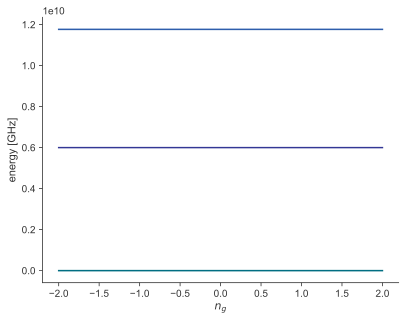

In [111]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [112]:
corrected_rr_freq = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma- cqrs[i]), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r[i] - cqrs[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        R(0, 2, 1e6)
        ])
    # f,k,A,chi = 
    cir.f_k_A_chi(pretty_print=True, Lj = Ljs[i])
    ham = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = Ljs[i])
    ee = ham.eigenenergies()
    ee -= ee[0]
    corrected_rr_freq[i] = ee[2]


         mode |       freq.  |       diss.  |       anha.  |
            0 |     3.23 GHz |       128 Hz |      215 MHz |
            1 |     7.01 GHz |      561 kHz |     1.17 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      215 MHz |              |
            1 |        1 MHz |     1.17 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.23 GHz |       271 Hz |      214 MHz |
            1 |     7.21 GHz |      576 kHz |     1.17 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      214 MHz |              |
            1 |     1000 kHz |     1.17 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.22 GHz |       485 Hz |      214 MHz |
            1 |     7.41 GHz |      592 kHz |     1.17 kHz |

Kerr coefficients (diagonal = Kerr, off-diag

 C:\Users\moret\AppData\Local\Temp\ipykernel_1264\664116265.py: 19

In [113]:
cir = Network([
    C(0,1,c_sigma- cqrs[i]), # transmon
    J(0,1,'Lj'),
    C(0,2,c_r[i] - cqrs[i]), # resonator
    L(0,2,l_r[i]),
    C(1,2, cqrs[i]), # coupling capacitor
    ])

In [114]:
g = 2*np.pi*EC/ (e_charge) * (Ej/EC/2)**(1/4) * cqrs / (c_r) * np.sqrt(2*planck_h * rr_freq_target * (c_r))
delta = (rr_freq_target - transmon.E01()) * 2*np.pi

lamb_shift = 2*g**2 / delta / 2 / np.pi
g/2/np.pi

array([1.32896933e+08, 1.13917292e+08, 8.96463011e+07, 6.05140027e+07])

In [115]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi/ np.sqrt(2)
    return abs(k - kappa_target)

In [116]:
cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15
cks

array([1.12530069e-14, 1.07874029e-14, 1.03530441e-14, 9.94707185e-15])

In [117]:
# I think this is the right one. Check with eigenmode!
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / rr_freq_target / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l - cqr_to_ground(cqrs) - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l - cqr_to_ground(cqrs) - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded -= cqrs
c_r_loaded -= cks
resonator_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
resonator_waveguide_lengths

array([0.00809886, 0.00792967, 0.0077609 , 0.0075962 ])

In [118]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_coupling = get_ck()
for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_coupling(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

Coupler width for qubit 0: 318.32 um
Finger control for qubit 0: 2.3518
Resonator length for qubit 0: 8098.9 um
Coupler width for qubit 1: 214.93 um
Finger control for qubit 1: 2.32
Resonator length for qubit 1: 7929.7 um
Coupler width for qubit 2: 132.21 um
Finger control for qubit 2: 2.2878
Resonator length for qubit 2: 7760.9 um
Coupler width for qubit 3: 61.066 um
Finger control for qubit 3: 2.2558
Resonator length for qubit 3: 7596.2 um


In [119]:
fl_traits = pd.read_csv("single_clockmons_readout_structure00.csv").values[0][1:]
tee_size = pd.read_csv("single_clockmons_readout_structure00.csv").values[1][1:]
res_length = pd.read_csv("single_clockmons_readout_structure00.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = []
transmission_line_tee_points += [float(fl_traits[0]) + (a+2*b)/2*1e6]
transmission_line_tee_points += [fl_traits[1] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[2] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[3] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[4] + (a+2*b)/2*1e6]

In [120]:
resonator_capacitance = c_r - cks -  cqrs

options = {
    "qubit_c": np.array([c_sigma]*4),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": cks,
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "frequency": [6.3, 8.306],
    "n_points": 1001,
    "type": "simple",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}

2-Port Network: '',  6.3-8.306 GHz, 1001 pts, z0=[50.+0.j 50.+0.j]


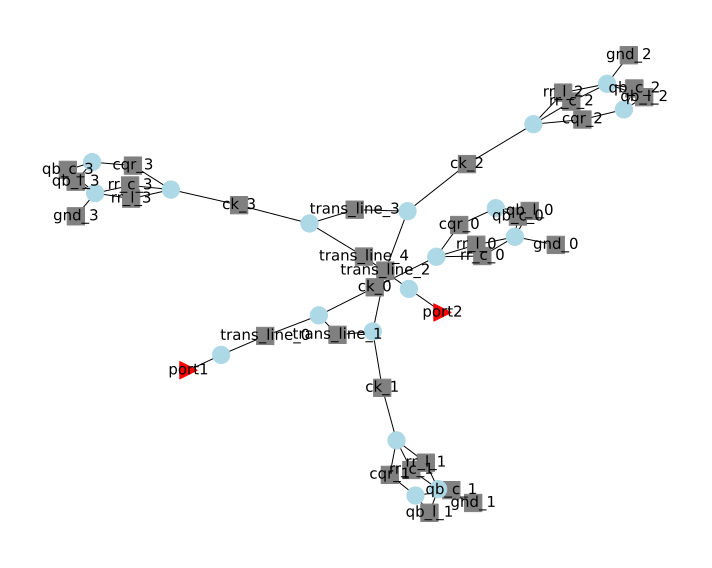

In [121]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

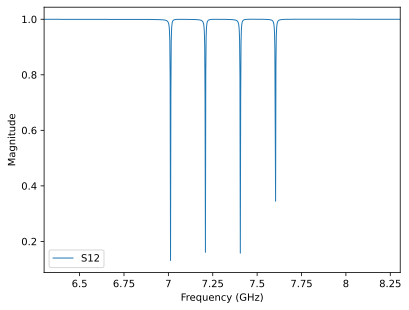

In [122]:
ntw.plot_s_mag(m=0, n=1, lw=1)
import matplotlib.pyplot as plt
# plt.vlines(x = 1/np.sqrt(c_r*l_r) / 2 / np.pi, ymin = 0, ymax = 1, colors="red")

# plt.vlines(x = 1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi +lamb_shift[-1], ymin = 0, ymax = 1, colors="red")
# plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
#            xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

# plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
#            xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

# # plt.vlines(x = 1/np.sqrt(c_r*l_r) / 2 / np.pi +lamb_shift, ymin = 0, ymax = 1, colors="red")
# plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
#            xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

In [123]:
cqr

2.701555016217182

In [124]:
# from modeling.resonance_fit import ResFit
# # https://eprints.gla.ac.uk/323700/1/323700.pdf
# initial_params = [1, 1e4, 1e7, 1, 1, 0, 0, 0]
# fitter = ResFit(ntw, 0, 5000, ideal = False)
# fitter.fit_resonance(initial_params=initial_params)
# fitter.plot_resonance()

In [125]:
# T1 Purcell:
delta = rr_freq_target - target_parameters["qubit_frequency"]
k_purcell = kappa_target* (g/2/np.pi/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell)
print(T1_purcell)

[0.00014418 0.00012559 0.00011407 0.00011126]


In [126]:
g_r_f = rr_freq_target**2*4*np.pi**2*Z0/2 * cks**2
c_r*2*np.pi*rr_freq_target/g_r_f

array([2006.05708888, 2063.3730057 , 2120.68892253, 2178.00483935])

In [127]:
# For when we'll need chargelines/fluxlines: https://quantumcomputing.stackexchange.com/questions/33136/how-to-estimate-the-losses-of-a-transmon-qubit-to-its-flux-bias-line

In [128]:
df = pd.DataFrame(columns=['resonator 01','qubit 01', 'anharmonicity','chi/2pi','g/2pi', 'C_sigma', 'Lj', 'Ic', 'T1 Purcell'], index=['qb0','qb1','qb2', 'qb3'])
df['resonator 01'] = rr_freq_target
df['qubit 01'] = qubit_freq_target
df['anharmonicity'] = anharmonicities
df['chi/2pi'] = [target_parameters["chi"]]*4
df['g/2pi'] = g/2/np.pi
df['C_sigma'] = [c_sigma]*4
df["Lj"] = Ljs
df['Ic'] = Ic
df['T1 Purcell'] = T1_purcell

In [129]:
df

,resonator 01,qubit 01,anharmonicity,chi/2pi,g/2pi,C_sigma,Lj,Ic,T1 Purcell
qb0,7.000000e+09,3.000000e+09,-2.702878e+08,500000.0,1.328969e+08,9.000000e-14,2.692977e-08,1.222090e-08,0.000144
qb1,7.200000e+09,4.000000e+09,-2.481659e+08,500000.0,1.139173e+08,9.000000e-14,1.573703e-08,2.091284e-08,0.000126
qb2,7.400000e+09,5.000000e+09,-2.400453e+08,500000.0,8.964630e+07,9.000000e-14,1.030266e-08,3.194380e-08,0.000114
qb3,7.600000e+09,6.000000e+09,-2.352306e+08,500000.0,6.051400e+07,9.000000e-14,7.263605e-09,4.530891e-08,0.000111


In [130]:
# Alternative to the minimization function that finds cqrs and Lj. Returns slightly different results for chi.
def minimize_func_alternative(x, c_r = None, l_r = None):
    EC = e_charge**2/(c_sigma)/2/planck_h
    Ic = get_Ic_from_Lj(x[1]*1e-9)
    Ej = Ic*phi0/2/pi/planck_h
    transmon = Transmon(EJ = Ej, EC=EC, ng = 0, ncut = 31)
    qubit = scq.GenericQubit(E=transmon.E01())
    resonator = scq.Oscillator(
        E_osc=1/np.sqrt(c_r*l_r) / 2 / np.pi,
        truncated_dim=8    # up to 3 photons (0,1,2,3)
    )
    hilbertspace = scq.HilbertSpace([qubit, resonator])
    bare_res_freq = 1/np.sqrt(c_r*l_r) / 2 / np.pi
    g = 2*np.pi*EC/ (e_charge) * (Ej/EC/2)**(1/4) * x[0]*1e-15 / (c_r) * np.sqrt(2*planck_h * bare_res_freq * (c_r))
    hilbertspace.add_interaction(
        g_strength = g/2/np.pi,
        op1 = qubit.sm_operator,
        op2 = resonator.creation_operator,
        add_hc = True,
        id_str="qubit-resonator"  # optional keyword argument
    )
    pname = 'ng'
    ng_vals = np.linspace(-0.5, 0.5, 1)
    paramvals_by_name = {pname: ng_vals}
    sweep = ParameterSweep(
        hilbertspace=hilbertspace,
        paramvals_by_name=paramvals_by_name,
        update_hilbertspace=lambda v: None,
        evals_count=10,
        subsys_update_info={},
    )
    chi = sweep["chi"]["subsys1":0, "subsys2":1][0, 1]/2
    

    err_chi = abs(chi - target_parameters["chi"])
    ee = hilbertspace.eigenvals()
    ee -= ee[0]
    
    chi = (g**2) * (1 / (ee[1] - ee[2]) + 1 / (ee[1] + ee[2]))

    err_freq = abs(ee[1] - target_parameters["qubit_frequency"])
    return err_chi, err_freq